In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ImageNormalize, LogStretch, ZScaleInterval
import numpy as np


from ComputeStats import ComputeStats
from CosmicRayLabel import CosmicRayLabel
import matplotlib.pyplot as plt

from scipy import ndimage
from matplotlib import colors
from matplotlib.patches import Rectangle, Circle
from photutils import detect_sources, detect_threshold
from photutils import detection
from photutils import source_properties, deblend_sources

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
 def get_data(fname):
        """ Grab the SCI extensions from fits file
        """
        pc = ('sci', 1) # Chip 2
        wf2 = ('sci', 2) # Chip 1
        wf3 = ('sci', 3)
        wf4 = ('sci', 4)
        detector_data = []
        with fits.open(fname) as hdu:
            for ext in [pc, wf2, wf3, wf4]:
                try:
                    ext = hdu.index_of(ext)
                    ext_data = hdu[ext].data
                except KeyError:
                    print('{1} is missing for {0}'.format(fname, ext))
                    ext1 = None
                else:
                    detector_data.append(ext_data)
        # If second ext is missing, only work with the first
        # Otherwise combine each DQ ext to make full-frame

        return detector_data
    

In [35]:
def find_sources(fname, deblend=False):
    """ 
    Generate segmentation map
    """
    sci_data = get_data(fname)
    
    # Generate a detection threshold for the segmentation mapping, we want everything with SNR higher than 5
    threshold = detect_threshold(sci_data[0], snr=5.)
    
    # Generate a kernel for use in the segmentation mapping, normalize it's value to 1
    sigma = 2. * gaussian_fwhm_to_sigma # convert FWHM of 2.75 pix to sigma
    kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
    kernel.normalize()
    data_list, segm_list = [], []
    for data in sci_data[:2]:
    # Find sources
        mean, median, std = sigma_clipped_stats(data, sigma_lower = 3, sigma_upper= 2)
        print('mean: {}, median: {}, std: {}'.format(mean, median, std))
        segm = detect_sources(data-median,
                          threshold=median+10*std,
                          npixels=4,
                          filter_kernel=kernel,
                          connectivity=8)
        
        
        if deblend:
            # Deblened sources
            print('deblending')
            try:
                segm_deblend = deblend_sources(sci_data[0],
                                           segm.data,
                                           npixels=4,
                                           nlevels=32,
                                           filter_kernel=kernel,
                                           contrast=0.1,
                                           connectivity=8,
                                          )
            except ValueError:
                pass
            else:
                segm = segm_deblend
#         return sci_data[0], segm_deblend
        segm_list.append(segm)
        data_list.append(data)
    return data_list, segm_list



In [36]:
flist = glob.glob('../crrejtab/WFPC2/mastDownload/HST/*/*c0m.fits')

In [37]:

f_1000 = []
for f in flist:
    if fits.getval(f,'exptime') > 1000:
        f_1000.append(f)

In [38]:
fname1 = f_1000[0]
fname2 = f_1000[1]

In [39]:
data1_list, segm1_list = find_sources(fname1, deblend=False)

mean: 3.88183719474868, median: 3.8386406898498535, std: 1.1404046418166893
mean: 2.5408237978920467, median: 2.4814984798431396, std: 1.0044161918923282


In [40]:
data2_list, segm2_list = find_sources(fname2, deblend=False)

mean: 3.8616358389085663, median: 3.7769970893859863, std: 1.120962871989505
mean: 2.6000919666624087, median: 2.4751949310302734, std: 1.0184271446021653


In [103]:
high_val = np.where(data1_list[1] > 3.8386406898498535 + 10*1.1404046418166893, 1, 0)

In [104]:
high_val.shape

(800, 800)

In [105]:
cmap = colors.ListedColormap(['black', 'white'])

In [106]:
threshold=2

In [107]:
label, num_feat = ndimage.label(high_val,structure=np.ones((3,3)))
print('Found {} objects'.format(num_feat))
cr_labels = label.ravel()  # Returns a flattened label
# Count up the number of pixels associated with each unique label
sizes = np.bincount(cr_labels)
arg_max = np.argmax(sizes)
sizes[arg_max] = 0
large_CRs = sizes > threshold

# Create a 2-D mask from the 1-D array of large cosmic rays, and set all
# labels of cosmic rays smaller than threshold to 0 so they are ignored.
label_mask = large_CRs[label]
high_val[~label_mask] = 0
label, num_feat = ndimage.label(high_val,
                                     structure=np.ones((3,3)))
print('After thresholding there are {} objects'.format(num_feat))

Found 4194 objects
After thresholding there are 2068 objects


<IPython.core.display.Javascript object>


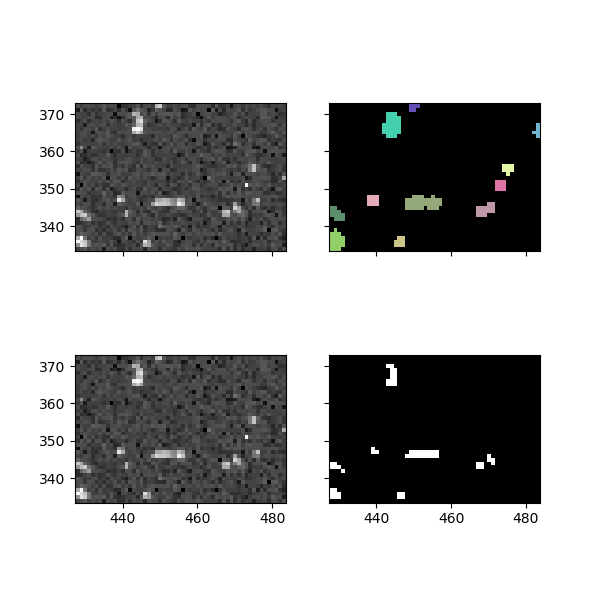

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6,6))
norm = ImageNormalize(data1_list[0], stretch=LogStretch(), vmin=0, vmax=500)

axes[0, 0].imshow(data1_list[1], norm=norm, cmap='gray', origin='lower')
axes[0, 1].imshow(segm1_list[1].data, origin='lower', cmap=segm1_list[1].cmap(random_state=1245))

axes[1, 0].imshow(data1_list[1], norm=norm, cmap='gray', origin='lower')
axes[1, 1].imshow(high_val, origin='lower', cmap=cmap)

In [109]:
len(np.unique(segm1_list[1].data))/1800

1.4022222222222223

In [11]:
from ComputeStats import ComputeStats
from CosmicRayLabel import CosmicRayLabel

In [12]:
label_obj = CosmicRayLabel(fname1)
label_obj.label_wfpc2_data()

mean: 3.88183719474868, median: 3.8386406898498535, std: 1.1404046418166893
mean: 2.5408237978920467, median: 2.4814984798431396, std: 1.0044161918923282
mean: 3.2131688486211005, median: 3.3673183917999268, std: 1.0712443065090416
mean: 2.562954882411579, median: 2.702826976776123, std: 1.0262639884600533


In [110]:
stats_obj = ComputeStats(fname1, label, label_obj.sci[1], label_obj.integration_time)

In [111]:
affected_tmp, rate_tmp, sizes_tmp, shapes_tmp, deposition_tmp = stats_obj.compute_stats(threshold=True)

[[7.11170404e-01 2.05780622e+02]
 [1.35513976e-01 3.41492112e+02]
 [0.00000000e+00 5.71201417e+02]
 ...
 [7.97733072e+02 4.67296294e+02]
 [7.97772041e+02 6.73220920e+02]
 [7.97330244e+02 7.02173329e+02]]
313.4813823699951
2068
801
712.6720886230469
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
0.004049249490102132


<IPython.core.display.Javascript object>


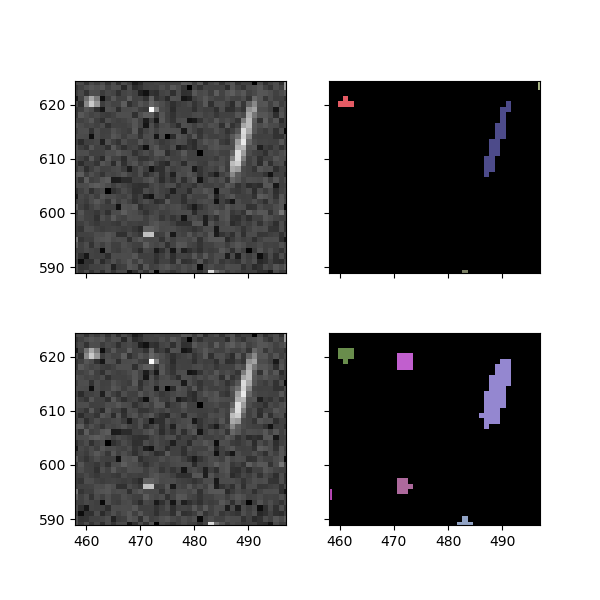

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6,6))
norm = ImageNormalize(label_obj.sci[1], stretch=LogStretch(), vmin=0, vmax=500)

axes[0, 0].imshow(label_obj.sci[1], norm=norm, cmap='gray', origin='lower')
axes[0, 1].imshow(label, origin='lower', cmap=segm1_list[1].cmap(random_state=1245))

axes[1, 0].imshow(data1_list[1], norm=norm, cmap='gray', origin='lower')
axes[1, 1].imshow(segm1_list[1].data, origin='lower', cmap=segm1_list[1].cmap(random_state=1245))